# General linear regression

<a target="_blank" href="https://colab.research.google.com/github/concordia-grad-computing-seminars/data-engineering/blob/main/ML/linear_regression/general.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

## Synthetic data set

To illustrate the concepts we will use a synthetic data set which we generate using the following function

In [2]:
def data(m=50, sigma=0.25):
    """
    Generates a data set of m points by adding Gaussian noise of variance sigma
    """
    x = np.random.rand(m)
    y = -1 + np.sin(2*np.pi*x) + np.random.normal(0, sigma,m)
    return (x, y)

An example

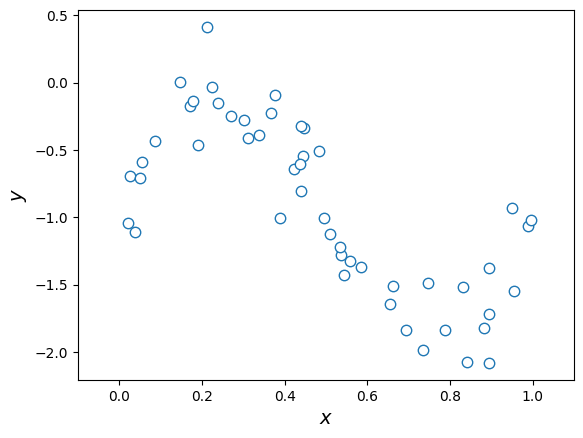

In [3]:
(x, y) = data()
plt.plot(x, y, ".", markersize=15, markerfacecolor='white')
plt.xlim([-0.1, 1.1])
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show()

## Basis Function Regression

Linear models can be extended to more general models. Let us consider a data set with one input variable $x$ and one output variable $y$. It becomes possible to adjust models that are a linear combinations of so called *basis functions*. Such models write like:
$$
y = \beta_0 + \beta_1 f_1(x) + \beta_2 f_2(x) + ... \beta_n f_n(x)
$$

The trick is to define $n$ features $x_i$ as $x_i = f_i(x)$ and the apply multi linear regression. The features matrix to be used in multi linear regression will like as:

$$
X = \left[\begin{array}{cc} 
f_1(x) & f_2(x) & ... & f_n(x)
\end{array}\right]
$$

where each column (except the first one, which contains only the number 1) will be computed according $f_i(x)$. The features matrix will, as usually, contain $m$ rows, where $m$ is the number of data points in the data set.

We present two examples here. 

### Polynomial regression

Polynomial regression aims to train models like this:
$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + ... \beta_n x^n
$$
Consequently, the $n$ auxiliary features needed for multi linear regressions are $x_i = x^i$. As polynomial regression is quite common, Scikit-Learn has a dedicated method for this in form of the [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) transformer. This transformer computes for us the needed features matrix $X$.

In [4]:
# Generate a small data set
(x, y) = data(m=5)

Let us build a features matrix which would correspond to a model of a cubic polynomial. The method `fit_transform` can be used. This method expects as input an array-like of shape (n_samples, n_features), as does the `fit` methods form the SciKit-Learn models.



In [5]:
# Apply PolynomialFeatures transformer
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(np.c_[x])

array([[0.30140134, 0.09084277, 0.02738013],
       [0.87174145, 0.75993316, 0.66246523],
       [0.92889754, 0.86285063, 0.80149983],
       [0.72563391, 0.52654458, 0.3820786 ],
       [0.15832297, 0.02506616, 0.00396855]])

Note how the features matrix is built. Each column $i$ is computed according $x^i$. This features matrix can be used as input for a linear regression model.

Let us illustrate this with a full example:

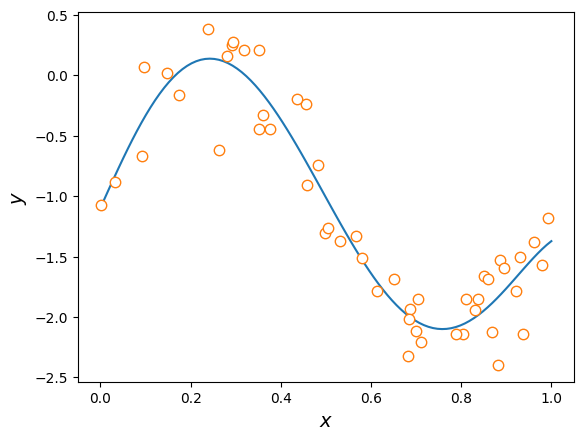

In [6]:
# Generate a data set
(x, y) = data()

# Compute features matrix for a polynomial model of degree 5
X = PolynomialFeatures(degree=5, include_bias=False).fit_transform(np.c_[x])

# Fit a linear model
reg = LinearRegression()
reg.fit(X, y)

# Plot data set and fitted model
x_fit = np.linspace(0, 1, 100)
X_fit = PolynomialFeatures(degree=5, include_bias=False).fit_transform(np.c_[x_fit])
y_fit = reg.predict(X_fit)
plt.plot(x_fit, y_fit, "-")
plt.plot(x, y, ".", markersize=15, markerfacecolor='white')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show()

### Using pipelines

As noted in the above example, the code becomes quite verbose. The reason is that we have to do multiple operations in a row (computing the features matrix and then feed it to the model and train it). Scikit-Learn has a very useful concept to chain multiple operations: [`pipelines`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). A simple way to creates pipelines is to use the function [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline).

Any classes having a `transform` method can be chained. The pipeline will successively call the `transform` methods of each class within the pipeline, using the output of the previous class as input to the next one.

For example

In [7]:
make_pipeline(PolynomialFeatures(degree=5, include_bias=False),
              LinearRegression())

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=False)),
                ('linearregression', LinearRegression())])

will chain the calculation of the features matrix and linear regression operation. The pipeline has a `fit` and `predict` method, which will call the `fit`, respectively the `predict`, method of the last class in the chain (the `LinearRegression` in our case). In fact the pipeline has even more methods as can be seen in the official documentation.

To illustrate its usage, we repeat the same example as above. Note how the code becomes shorter and more intuitive to read.

In [8]:
# Generate a data set
(x, y) = data()

# Pipeline chaining the calculation of the features matrix and linear regression
poly_model = make_pipeline(PolynomialFeatures(degree=5, include_bias=False),
                           LinearRegression())

# Train full chain
poly_model.fit(np.c_[x], y)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=False)),
                ('linearregression', LinearRegression())])

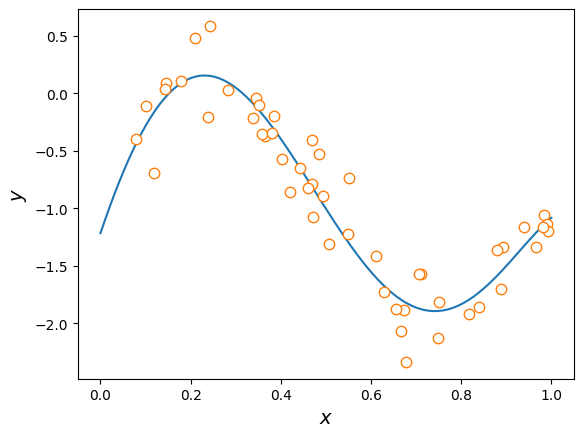

In [9]:
# Plot data set and fitted model
x_fit = np.linspace(0, 1, 100)
y_fit = poly_model.predict(np.c_[x_fit])
plt.plot(x_fit, y_fit, "-")
plt.plot(x, y, ".", markersize=15, markerfacecolor='white')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show()

### Gaussian basis functions

To illustrate the usage of more general basis functions, let us consider the example of Gaussian basis functions. Gaussian basis functions $\phi_i$ are defined as:
$$
\phi_i(x) = \exp \left[ -\frac{(x-\mu_i)^2}{2\sigma^2} \right]
$$

with two hyper-parameters $\mu_i$ and $\sigma$ which define the behavior of the Gaussian basis function (note one could as well consider even more general cases where these hyper-parameters $\sigma$ is as well different for each function $f_i$).

The hyper-parameters $\mu_i$ are the centers around which the Gaussian basis functions are built and $\sigma$ is the spatial extension of each of them.

The linear model we aim to train will look like:
$$
y = \beta_0 + \sum_{i=1}^n \beta_i\phi_i(x)
$$

This linear model acts a little similarly as Lagrangian polynomial interpolation. Each basis function will take into account the vicinity of its center. 

Let us define a series of $n$ Gaussian basis functions with a spatial extension $s$ for each of them. We distribute uniformly their centers within the interval $[0, 1]$. Pay attention to the numbering of the basis functions which starts with 1.

In [10]:
# number of basis functions
n = 5

# locations of Gaussian basis functions
mu_i = np.linspace(0, 1, n) 

def phi_i(x, i, s):
    """
    Gaussian basis function with spatial extension s
    """
    return np.exp(-(x-mu_i[i-1])**2/(2*s**2))

As an example, lets plot these Gaussian basis functions.

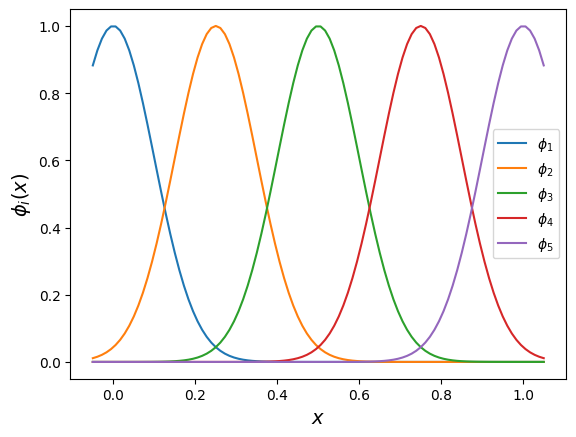

In [11]:
x = np.linspace(-0.05, 1.05, 100)
for i in range(1, 6):
    plt.plot(x, phi_i(x, i, 0.1), label='$\phi_' + str(i) + '$')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$\phi_{i}(x)$', fontsize=14)
plt.legend()
plt.show()

Gaussian basis functions are not built into SciKit-Learn. We have to write a custom transformer that to create them. In order to be able to use these custom transformer in a pipeline, we need to define a `transform` and `fit` method having the same signature as transformers in SciKit-Learn. To make sure we have this identical signatures, we derive our transformer from the base classe of a SciKit-Learn [`BaseEstimator`](https://scikit-learn.org/stable/developers/develop.html) (and use the [`TransformerMixin`](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) mixing).

This is part is a little technical, but the example below can be used as a template to use for other basis functions.

In [12]:
class GaussianFeatures(BaseEstimator, TransformerMixin):
    """
    Transformer for uniformly spaced Gaussian basis functions for one-dimensional input
    """
    
    def __init__(self, n, s):
        self.n = n
        self.s = s
        self.mu_i = np.linspace(0, 1, n) 
    
    def _gauss_basis(self, x, i):
        return np.exp(-(x-self.mu_i[i])**2/(2*self.s**2))
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_b = np.c_[self._gauss_basis(X, 0)]
        for i in range(1, self.n):
            X_b = np.c_[X_b, self._gauss_basis(X, i)]
        return X_b

With this custom transformer class, building a pipeline and training follows the same structure as in the case of polynomial regression.

In [13]:
# Generate a data set
(x, y) = data()
X = np.c_[x]

# Pipeline chaining the calculation of the features matrix and linear regression
gauss_model = make_pipeline(GaussianFeatures(5, 0.1),
                            LinearRegression())

# Train full chain
gauss_model.fit(X, y)

Pipeline(steps=[('gaussianfeatures', GaussianFeatures(n=5, s=0.1)),
                ('linearregression', LinearRegression())])

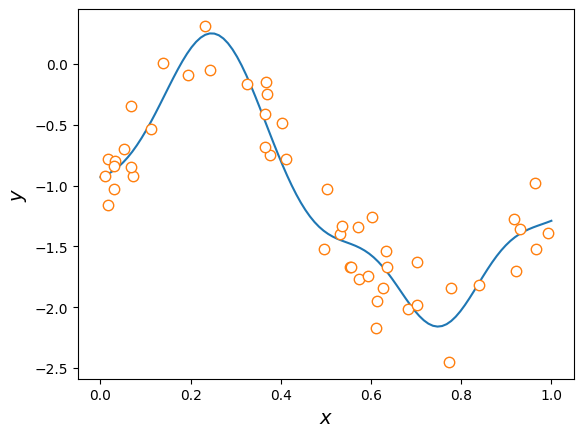

In [14]:
# Plot data set and fitted model
x_fit = np.linspace(0, 1, 100)
y_fit = gauss_model.predict(np.c_[x_fit])
plt.plot(x_fit, y_fit, "-")
plt.plot(X, y, ".", markersize=15, markerfacecolor='white')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show()